# Comparative Encoder it4

## 7:25 PM 6.12.22

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
ver = 4

In [2]:
for i in plt.get_fignums():
    plt.close(i)

## Load SILVA Dataset

In [3]:
from Bio import SeqIO
import numpy as np
from tqdm.notebook import tqdm
s = np.array([record for record in tqdm(SeqIO.parse('silva.fasta', "fasta"))], dtype=object)

0it [00:00, ?it/s]

In [4]:
lengths = []
for i in s:
    lengths.append(len(i.seq))
lengths = np.asarray(lengths)

In [5]:
np.median(lengths)

2902.0

In [6]:
len(lengths[lengths < 2930]) / len(lengths)

0.7652805820587602

(array([7.50000e+03, 5.96100e+03, 7.61500e+03, 6.61670e+04, 1.23358e+05,
        8.96700e+03, 4.21700e+03, 3.17100e+03, 3.38000e+02, 3.70000e+01]),
 array([1900., 2148., 2396., 2644., 2892., 3140., 3388., 3636., 3884.,
        4132., 4380.]),
 <BarContainer object of 10 artists>)

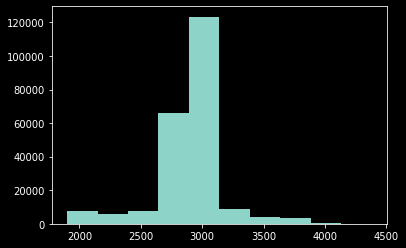

In [7]:
plt.hist(lengths)

In [8]:
import multiprocessing as mp
from tqdm.notebook import tqdm
LENGTH = 2930
def fn(i):
    seq = str(i.seq)
    trimmed = seq[:min([LENGTH, len(seq)])]
    padded = trimmed + ('N' * (LENGTH - len(trimmed)))
    return np.array(list(padded))
with mp.Pool(75) as p:
    string_seqs = np.array(list(tqdm(p.imap(fn, s, chunksize=100), total=s.shape[0])))

  0%|          | 0/227331 [00:00<?, ?it/s]

In [9]:
string_seqs[2].shape

(2930,)

In [10]:
BASES = ['A', 'U', 'G', 'C']
def fn(i):
    enc_seq = np.empty((LENGTH, 5), dtype=np.intc)
    for bp in range(string_seqs.shape[1]):
        idx = BASES.index(i[bp]) if i[bp] in BASES else 4
        enc_seq[bp] = [1 if j == idx else 0 for j in range(5)]
    return enc_seq
with mp.Pool() as p:
    seqs = np.asarray(list(tqdm(p.imap(fn, string_seqs, chunksize=10), total=string_seqs.shape[0])))

  0%|          | 0/227331 [00:00<?, ?it/s]

In [11]:
desc = np.array([i.description.split(' ')[1] for i in s])
num_items = np.vectorize(lambda i: len(i.split(';')))(desc)
parsable = num_items == 7
raw_tax = desc[parsable]
tax = []
for i in raw_tax:
    tax.append(i.split(';'))
tax = np.array(tax)
seqs = seqs[parsable]

## Preprocessing

In [12]:
codes = np.array(['A', 'U', 'G', 'C', ''])
def to_str(s):
    return ''.join(codes[s])

import multiprocessing as mp
def decode(sample):
    with mp.Pool(25) as p:
        return np.array(list(tqdm(p.imap(to_str, sample, chunksize=100), total=sample.shape[0])))
str_seqs = decode(seqs.argmax(axis=-1))

  0%|          | 0/180516 [00:00<?, ?it/s]

In [13]:
from sklearn.model_selection import train_test_split
seqs_train, seqs_val, str_seqs_train, str_seqs_val = train_test_split(seqs, str_seqs, test_size=.01)

In [57]:
# pairs = np.array(np.meshgrid(np.arange(seqs_val.shape[0]), np.arange(seqs_val.shape[0]))).T.reshape(-1, 2)
# val_x1 = seqs_val[pairs[:, 0]]
# val_x2 = seqs_val[pairs[:, 1]]

MemoryError: Unable to allocate 282. GiB for an array with shape (5171076, 2930, 5) and data type int32

In [10]:
# from Bio import pairwise2
# def align(pair):
#     return pairwise2.align.localxx(str_seqs_val[pair[0]], str_seqs_val[pair[1]], score_only=True)

# import multiprocessing
# with multiprocessing.Pool() as p:
#     alignments = np.array(list(tqdm(p.imap(align, pairs, chunksize=1000), total=pairs.shape[0])))

# val_labels = np.tanh((300 - alignments) / 100)

  0%|          | 0/3261636 [00:00<?, ?it/s]

## Model Definition

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [15]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, a, b):
        return tf.reduce_sum(tf.square(a - b), -1)

In [16]:
import tensorflow as tf
from tensorflow.keras import layers

mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    inputs = layers.Input((LENGTH, 5))
    den = layers.Dense(50)(inputs)
    res = layers.Reshape((LENGTH // 5, 50 * 5))(den)
    
    conv = layers.Conv1D(20, 3)(res)
    maxpool = layers.MaxPooling1D()(conv)
    res2 = layers.Flatten()(maxpool)
    norm = layers.BatchNormalization()(res2)
    den = layers.Dense(300 * 50 * 3)(norm)
    res = layers.Reshape((300, 50 * 3))(den)

    trans = TransformerBlock(50 * 3, 4, 300)(res)
    norm = layers.BatchNormalization()(trans)

    trans = TransformerBlock(50 * 3, 4, 300)(norm)
    norm = layers.BatchNormalization()(trans)

    conv = layers.Conv1D(20, 3)(norm)
    maxpool = layers.MaxPooling1D()(conv)
    res2 = layers.Flatten()(maxpool)
    norm = layers.BatchNormalization()(res2)

    out = layers.Dense(2)(norm)

    embeddings = tf.keras.Model(inputs=inputs, outputs=out)
embeddings.summary()

2022-06-25 21:00:57.045496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-25 21:00:59.018170: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2022-06-25 21:00:59.023285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38420 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2930, 5)]         0         
                                                                 
 dense (Dense)               (None, 2930, 50)          300       
                                                                 
 reshape (Reshape)           (None, 586, 250)          0         
                                                                 
 conv1d (Conv1D)             (None, 584, 20)           15020     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 292, 20)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5840)              0         
                                                             

In [17]:
from keras import backend as K
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
#     return 1 - K.square(r)
    return 1 - r

def combined_loss(y_true, y_pred):
    return correlation_coefficient_loss(y_true, y_pred) + tf.keras.losses.MeanSquaredError(
        tf.keras.losses.Reduction.NONE)(y_true, y_pred)

with mirrored_strategy.scope():
    inputa = layers.Input((LENGTH, 5), name='input_a')
    inputb = layers.Input((LENGTH, 5), name='input_b')
    distances = DistanceLayer()(
        embeddings(inputa),
        embeddings(inputb),
    )
    siamese_network = tf.keras.Model(inputs=[inputa, inputb], outputs=distances)
    siamese_network.compile(optimizer='adam',
                    loss=correlation_coefficient_loss,
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])
siamese_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_a (InputLayer)           [(None, 2930, 5)]    0           []                               
                                                                                                  
 input_b (InputLayer)           [(None, 2930, 5)]    0           []                               
                                                                                                  
 model (Functional)             (None, 2)            263817782   ['input_a[0][0]',                
                                                                  'input_b[0][0]']                
                                                                                                  
 distance_layer (DistanceLayer)  (None,)             0           ['model[0][0]',            

### Load Model

In [16]:
custom_objects = {'combined_loss': combined_loss}
with tf.keras.utils.custom_object_scope(custom_objects):
    siamese_network_it2 = tf.keras.models.load_model('Models/comparative_encoder2/full_model')
    embeddings_it2 = tf.keras.models.load_model('Models/comparative_encoder2/encoder')

In [114]:
siamese_network.set_weights(siamese_network_it2.get_weights())

In [36]:
weights = siamese_network.get_weights()

In [37]:
siamese_network.set_weights(weights)

## Training

In [97]:
rng = np.random.default_rng()
perm = rng.permutation(seqs_train.shape[0])
a = str_seqs_train[perm]

codes = np.array(['A', 'U', 'G', 'C', ''])
from Bio import pairwise2
def align(pair):
    return pairwise2.align.localxx(pair[0], pair[1], score_only=True)


import multiprocessing
with multiprocessing.Pool() as p:
    aln = np.array(list(tqdm(p.imap(align, zip(a, str_seqs_train), chunksize=10), total=a.shape[0])))

  0%|          | 0/225057 [00:00<?, ?it/s]

(array([  367.,  6261., 11081., 30790., 25247., 53346., 59703., 22356.,
         8359.,  7547.]),
 array([1215. , 1386.5, 1558. , 1729.5, 1901. , 2072.5, 2244. , 2415.5,
        2587. , 2758.5, 2930. ]),
 <BarContainer object of 10 artists>)

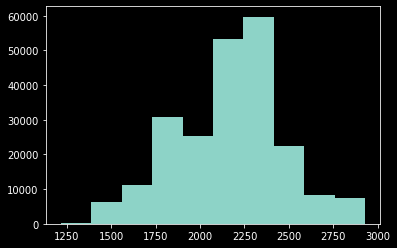

In [85]:
plt.hist(aln)

In [22]:
# from Bio import pairwise2
# def dissimilarity(pair):
#     return (20 / (pairwise2.align.localxx(pair[0], pair[1], score_only=True) / 300)) - 20
from Bio import pairwise2
def align(pair):
    return pairwise2.align.localxx(pair[0], pair[1], score_only=True)

codes = np.array(['A', 'U', 'G', 'C', ''])
def to_str(s):
    return ''.join(codes[s])

import multiprocessing as mp
def decode(sample):
    with mp.Pool(25) as p:
        return np.array(list(tqdm(p.imap(to_str, sample, chunksize=100), total=sample.shape[0])))

from sklearn.model_selection import train_test_split
rng = np.random.default_rng()
def randomized_epoch(data, str_data):
    p1 = rng.permutation(data.shape[0])
    p2 = rng.permutation(data.shape[0])
    x1, x1_str = data[p1], str_data[p1]
    x2, x2_str = data[p2], str_data[p2]
    
    import multiprocessing
    with multiprocessing.Pool() as p:
        aln = np.array(list(tqdm(p.imap(align, zip(x1_str, x2_str), chunksize=10), total=x1_str.shape[0])))
    y = np.tanh((2930 - aln) / 1000)
    
    train_data = tf.data.Dataset.from_tensor_slices(({'input_a': x1, 'input_b': x2}, y))
    train_data = train_data.batch(100)
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    train_data = train_data.with_options(options)
    
    siamese_network.fit(train_data, epochs=1)

# def validate():
#     val_data = tf.data.Dataset.from_tensor_slices((
#         {'input_a': val_x1[:100000], 'input_b': val_x2[:100000]},))
#     val_data = val_data.batch(100)
#     options = tf.data.Options()
#     options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
#     val_data = val_data.with_options(options)
#     pred = siamese_network.predict(val_data)
#     return np.corrcoef(pred, val_labels[:100000])[0, 1] ** 2, ((pred - val_labels[:100000]) ** 2).mean()

import time
def train(epochs):
    for i in range(epochs):
        start = time.time()
        print(f'Epoch {i + 1}:')
        randomized_epoch(seqs_train, str_seqs_train)
#         val_r, val_mse = validate()
#         print(f'val_mse: {val_mse}; val_r2: {val_r}')
        print(f'Epoch time: {time.time() - start}')

In [ ]:
train(300)

Epoch 1:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2939 - mean_absolute_error: 80939.9609
Epoch time: 452.72094225883484
Epoch 2:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2926 - mean_absolute_error: 85890.7031
Epoch time: 450.92360520362854
Epoch 3:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2898 - mean_absolute_error: 86633.6250
Epoch time: 457.79323506355286
Epoch 4:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2905 - mean_absolute_error: 90122.1328
Epoch time: 450.88169264793396
Epoch 5:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2886 - mean_absolute_error: 87817.9609
Epoch time: 454.4559597969055
Epoch 6:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2854 - mean_absolute_error: 95469.2422
Epoch time: 454.3991618156433
Epoch 7:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2866 - mean_absolute_error: 98668.6719
Epoch time: 453.49254155158997
Epoch 8:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2850 - mean_absolute_error: 101965.4062
Epoch time: 456.4929759502411
Epoch 9:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2858 - mean_absolute_error: 101647.9141
Epoch time: 454.8253092765808
Epoch 10:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2821 - mean_absolute_error: 105900.7734
Epoch time: 457.68012714385986
Epoch 11:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2802 - mean_absolute_error: 112369.0234
Epoch time: 453.9567894935608
Epoch 12:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2843 - mean_absolute_error: 119635.1328
Epoch time: 456.30442452430725
Epoch 13:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2804 - mean_absolute_error: 130686.9766
Epoch time: 454.0252614021301
Epoch 14:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2841 - mean_absolute_error: 121004.1484
Epoch time: 455.5563864707947
Epoch 15:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2822 - mean_absolute_error: 124539.3203
Epoch time: 454.15208888053894
Epoch 16:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2839 - mean_absolute_error: 115627.1641
Epoch time: 456.54948687553406
Epoch 17:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2822 - mean_absolute_error: 123566.6250
Epoch time: 456.1668496131897
Epoch 18:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2847 - mean_absolute_error: 122022.6953
Epoch time: 457.9291534423828
Epoch 19:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2868 - mean_absolute_error: 117813.5312
Epoch time: 457.47093892097473
Epoch 20:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2832 - mean_absolute_error: 125057.5938
Epoch time: 452.88643288612366
Epoch 21:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2813 - mean_absolute_error: 135015.6094
Epoch time: 452.36711263656616
Epoch 22:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2873 - mean_absolute_error: 119036.5312
Epoch time: 452.71794724464417
Epoch 23:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2873 - mean_absolute_error: 110876.5469
Epoch time: 457.7524964809418
Epoch 24:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2876 - mean_absolute_error: 109681.9922
Epoch time: 451.8836543560028
Epoch 25:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2897 - mean_absolute_error: 114455.3594
Epoch time: 453.2439250946045
Epoch 26:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2877 - mean_absolute_error: 120044.7031
Epoch time: 457.5048460960388
Epoch 27:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2839 - mean_absolute_error: 131365.8594
Epoch time: 455.3418815135956
Epoch 28:


  0%|          | 0/178710 [00:00<?, ?it/s]

1788/1788 [==============================] - 247s 138ms/step - loss: 0.2818 - mean_absolute_error: 136369.3125
Epoch time: 459.03103613853455
Epoch 29:


  0%|          | 0/178710 [00:00<?, ?it/s]

Process ForkPoolWorker-18357:
Process ForkPoolWorker-18427:
Process ForkPoolWorker-18301:
Process ForkPoolWorker-18380:
Process ForkPoolWorker-18378:
Process ForkPoolWorker-18403:
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Process ForkPoolWorker-18416:
Process ForkPoolWorker-18364:
Process ForkPoolWorker-18366:
Process ForkPoolWorker-18411:
Process ForkPoolWorker-18365:
Process ForkPoolWorker-18381:
Process ForkPoolWorker-18396:
Process ForkPoolWorker-18351:
Process ForkPoolWorker-18425:
Process ForkPoolWorker-18358:
Process ForkPoolWorker-18305:
Process ForkPoolWorker-18312:
Process ForkPoolWorker-18426:
Process ForkPoolWorker-18362:
Process ForkPoolWorker-18333:


Traceback (most recent call last):
  File "/opt/apps/intel19/python3/3.9.7/lib/python3.9/multiprocessing/pool.py", line 853, in next
    item = self._items.popleft()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_1639996/1961420025.py", line 27, in randomized_epoch
    aln = np.array(list(tqdm(p.imap(align, zip(x1_str, x2_str), chunksize=10), total=x1_str.shape[0])))
  File "/home1/08947/nkalidas/.local/lib/python3.9/site-packages/tqdm/notebook.py", line 258, in __iter__
    for obj in it:
  File "/home1/08947/nkalidas/.local/lib/python3.9/site-packages/tqdm/std.py", line 1195, in __iter__
    for obj in iterable:
  File "/opt/apps/intel19/python3/3.9.7/lib/python3.9/multiprocessing/pool.py", line 420, in <genexpr>
    return (item for chunk in result for item in chunk)
  File "/opt/apps/intel19/python3/3.9.7/lib/python3.9/multiprocessing/pool.py", line 858, in next
    

Process ForkPoolWorker-18335:
Process ForkPoolWorker-18415:
Process ForkPoolWorker-18329:
Process ForkPoolWorker-18421:
Process ForkPoolWorker-18356:
Process ForkPoolWorker-18349:
Process ForkPoolWorker-18342:
Process ForkPoolWorker-18344:
Process ForkPoolWorker-18348:
Process ForkPoolWorker-18423:
Process ForkPoolWorker-18404:
Process ForkPoolWorker-18361:
Process ForkPoolWorker-18390:
Process ForkPoolWorker-18314:
Process ForkPoolWorker-18400:
Process ForkPoolWorker-18307:
Process ForkPoolWorker-18334:
Process ForkPoolWorker-18405:
Process ForkPoolWorker-18377:
Process ForkPoolWorker-18326:
Process ForkPoolWorker-18322:
Process ForkPoolWorker-18347:
Process ForkPoolWorker-18412:
Process ForkPoolWorker-18343:
Process ForkPoolWorker-18318:
Process ForkPoolWorker-18417:
Process ForkPoolWorker-18422:
Process ForkPoolWorker-18371:
Process ForkPoolWorker-18323:
Process ForkPoolWorker-18372:
Process ForkPoolWorker-18354:
Process ForkPoolWorker-18389:
Process ForkPoolWorker-18392:
Process Fo

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_1639996/1961420025.py", line 6, in align
    return pairwise2.align.localxx(pair[0], pair[1], score_only=True)
Traceback (most recent call last):
Traceback (most recent call last):
KeyboardInterrupt
  File "/home1/08947/nkalidas/.local/lib/python3.9/site-packages/Bio/pairwise2.py", line 560, in _align
    matrices = _make_score_matrix_fast(
Traceback (most recent call last):
Trac

TypeError: object of type 'NoneType' has no len()

In [66]:
siamese_network.save(f'Models/comparative_encoder{ver}/full_model')
embeddings.save(f'Models/comparative_encoder{ver}/encoder')

In [445]:
embeddings.trainable = False
siamese_network.trainable = False

## Evaluation on SILVA

In [58]:
seq_reps = embeddings.predict(seqs, batch_size=100)

2022-06-26 11:40:09.343341: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1025928"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2866"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_P

1806/1806 [==============================] - 20s 11ms/step


### Correlation Plot

  0%|          | 0/10000 [00:00<?, ?it/s]

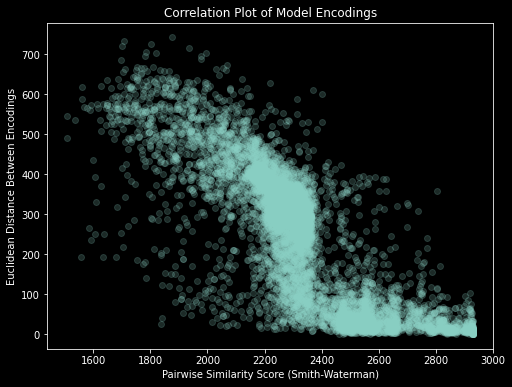

In [68]:
import random
from scipy.spatial.distance import euclidean
codes = BASES + ['N']
def to_str(s):
    return ''.join(codes[i] for i in s)
def evaluate(_):
    a = random.randint(0, seq_reps.shape[0] - 1)
    b = random.randint(0, seq_reps.shape[0] - 1)
    pred = euclidean(seq_reps[a], seq_reps[b])
    first = to_str(seqs[a].argmax(-1))
    second = to_str(seqs[b].argmax(-1))
    aln = align((first, second))
#     score = np.tanh((300 - aln) / 100)
    score = aln
    return [score, pred]
with mp.Pool(50) as p:
    results = np.array(list(tqdm(p.imap_unordered(evaluate, range(10000), chunksize=10), total=10000)))
# results = np.asarray([evaluate() for i in tqdm(range(10000))])
f = plt.figure(figsize=(8, 6))
plt.scatter(results[:, 0], results[:, 1], alpha=.2)
plt.xlabel('Pairwise Similarity Score (Smith-Waterman)')
plt.ylabel('Euclidean Distance Between Encodings')
plt.title('Correlation Plot of Model Encodings')
plt.savefig(f'Results/it{ver}/silva/eval/comparative_enc_eval.png')

In [30]:
results[:, 0].mean()

2327.854

In [31]:
np.corrcoef(results[:, 0], results[:, 1])

array([[ 1.        , -0.79081853],
       [-0.79081853,  1.        ]])

In [32]:
np.mean((results[:, 0] - results[:, 1]) ** 2)

5152360.194179053

### SILVA Clustering

<function matplotlib.pyplot.show(close=None, block=None)>

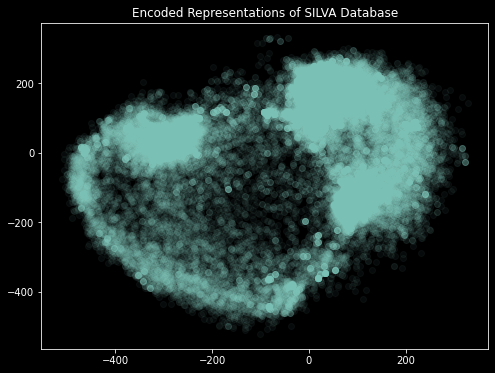

In [69]:
import matplotlib.pyplot as plt
x, y = np.array(seq_reps).T
f = plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=.05, marker='o')
plt.title("Encoded Representations of SILVA Database")
plt.savefig(f'Results/it{ver}/silva/silva_all.png')
plt.show

#### Domain

In [70]:
archaea = seq_reps[tax[:, 0] == 'Archaea']
bacteria = seq_reps[tax[:, 0] == 'Bacteria']
eukaryota = seq_reps[tax[:, 0] == 'Eukaryota']

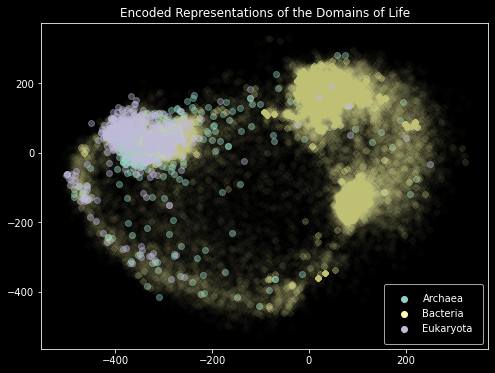

In [71]:
f = plt.figure(figsize=(8, 6))
plt.scatter(archaea[:, 0], archaea[:, 1], alpha=.4)
plt.scatter(bacteria[:, 0], bacteria[:, 1], alpha=.015)
plt.scatter(eukaryota[:, 0], eukaryota[:, 1], alpha=.4)
leg = plt.legend(['Archaea', 
                  'Bacteria',
                  'Eukaryota'],
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.title('Encoded Representations of the Domains of Life')
plt.savefig(f'Results/it{ver}/silva/silva_domains.png')
plt.show()

#### Phylum (Bacteria)

In [72]:
a, b = np.unique(tax[tax[:, 0] == 'Bacteria'][:, 1], return_counts=True)
genuses = a[b > 1000]

In [73]:
plottable = np.isin(tax[:, 1], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[tax[plottable][:, 1] == genuses[i], i] = 1
plottable_seqs = seq_reps[plottable]

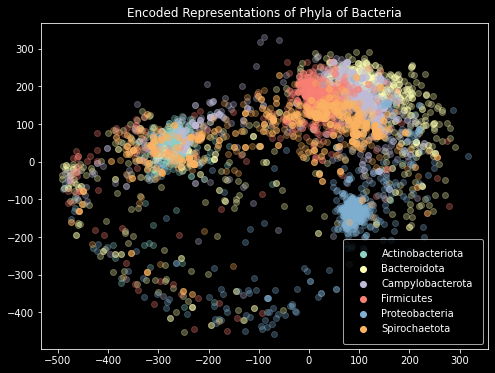

In [74]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Phyla of Bacteria")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig(f'Results/it{ver}/silva/silva_phylum.png')
plt.show()

#### Class (Proteobacteria)

In [46]:
a, b = np.unique(tax[tax[:, 1] == 'Proteobacteria'][:, 2], return_counts=True)
genuses = a[b > 500]

In [47]:
plottable = np.isin(tax[:, 2], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[tax[plottable][:, 2] == genuses[i], i] = 1
plottable_seqs = seq_reps[plottable]

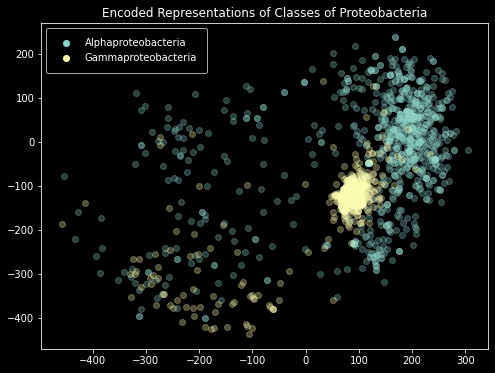

In [48]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Classes of Proteobacteria")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig(f'Results/it{ver}/silva/silva_class.png')
plt.show()

#### Order (Alphaproteobacteria)

In [49]:
a, b = np.unique(tax[tax[:, 2] == 'Alphaproteobacteria'][:, 3], return_counts=True)
genuses = a[b > 500]

In [50]:
plottable = np.isin(tax[:, 3], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[tax[plottable][:, 3] == genuses[i], i] = 1
plottable_seqs = seq_reps[plottable]

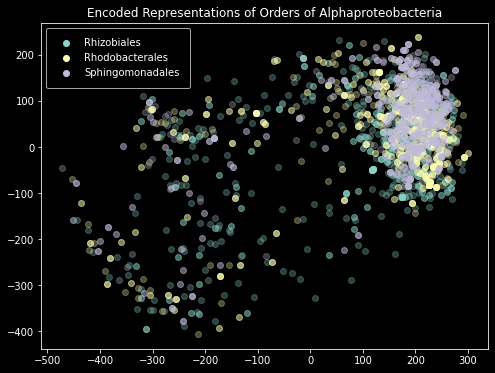

In [51]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Orders of Alphaproteobacteria")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig(f'Results/it{ver}/silva/silva_order.png')
plt.show()

#### Genus (Rhizobiales Rhizobiaceae)

In [52]:
a, b = np.unique(tax[tax[:, 4] == 'Rhizobiaceae'][:, 5], return_counts=True)
genuses = a[b > 500]

In [53]:
plottable = np.isin(tax[:, 5], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[tax[plottable][:, 5] == genuses[i], i] = 1
plottable_seqs = seq_reps[plottable]

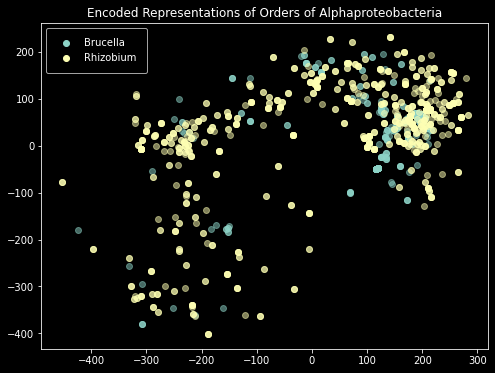

In [54]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.5, marker='o')
ax.set_title("Encoded Representations of Orders of Alphaproteobacteria")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig(f'Results/it{ver}/silva/silva_genus.png')
plt.show()

# ANC Data

## Preprocessing

### Load

In [70]:
label_map = {
    "S002": "black",
    "S001": "grey",
    "S003": "unpigmented"
}
def read_ion_reporter(path):
    import os
    import pandas as pd
    import numpy as np
    from Bio import SeqIO
    from tqdm.notebook import tqdm
    import re

    paths = np.array([])  # Get paths to all fasta files
    for root, dirs, files in os.walk(path):
        paths = np.append(paths, [os.path.join(root, i) for i in files if i.endswith(".fasta")])

    def read(i):  # Function to parse a fasta file and get all records
        s = np.array([record for index, record in enumerate(SeqIO.parse(i, "fasta"))] + [0], dtype=object)
        s = s[:-1]  # We append 0 and remove it so that single element arrays get parsed as such
        l = np.full_like(s, label_map[i.split("/")[-1][:4]])
        return s, l

    seqs, labels, desc = np.array([]), np.array([]), np.array([])
    for i in paths:  # Parse all sequences, generate labels
        s, l = read(i)
        seqs = np.append(seqs, s)
        labels = np.append(labels, l)
    # flattened_seqs = np.concatenate(seqs)  # Flatten because we don't care about which sample the data came from
    string_seqs = np.vectorize(lambda i: str(i.seq))(seqs)  # Convert to strings
    descriptions = np.vectorize(lambda i: i.description)(seqs)

    return string_seqs, labels, descriptions

arlington, arlington_labels, arlington_desc = read_ion_reporter("Data/Arlington Processed")

### Header Parsing

In [71]:
import re
def get_size(s: str):
    parts = s.split('|')
    idx = -1
    for i in range(len(parts)):
        if re.search(r'\.', parts[i]):
            idx = i
            break
    if idx == -1:
        return 0
    return len(parts[i + 1:])

import numpy as np
arlington_known = np.vectorize(get_size)(arlington_desc) != 0
arlington = arlington[arlington_known]
arlington_labels = arlington_labels[arlington_known]
arlington_desc = arlington_desc[arlington_known]

def get_tax(s: str):
    parts = s.split('|')
    for i in range(len(parts)):
        if re.search(r'\.', parts[i]):
            break
    tax = [x.strip('[]') for x in parts[i + 1:-1]]
    unc = ["UNKNOWN"] * 6
    cond = ['/' not in i and 'sp.' not in i for i in tax]
    return np.where(cond, tax, unc)

arlington_tax = np.empty((arlington_desc.shape[0], 6), dtype=object)
for i in range(arlington_desc.shape[0]):
    arlington_tax[i, :] = get_tax(arlington_desc[i])

def get_conf(s: str):
    parts = s.split('|')
    for i in range(len(parts)):
        if re.search(r'\.', parts[i]):
            break
    return float(parts[i])

arlington_conf = np.vectorize(get_conf)(arlington_desc)

def get_abund(s: str):
    parts = s.split('|')
    for i in range(len(parts)):
        if re.search(r'\.', parts[i]):
            break
    return int(parts[i - 1])

arlington_abund = np.vectorize(get_abund)(arlington_desc)

### Sequence Encoding

In [72]:
def preprocess_reads(x):
    from tqdm.notebook import tqdm
    from sklearn import preprocessing
    import numpy as np

    BASES = ["A", "T", "G", "C"]

    LENGTH = 300

    # mask = np.vectorize(len)(x) >= LENGTH
    seqs = np.vectorize(lambda i: i[:LENGTH])(x)

    print("Encoding sequences...")
    # Sequence encoding
    def encode_seq(seq: str):  # Function to encode a sequence using one-hot encoding
        idx = [BASES.index(char) for char in seq]
        return [[(1 if j == i else 0) for j in range(5)] for i in idx]
    # Time consuming step, vectorize if possible!!!
    final_seqs = np.empty((seqs.shape[0], LENGTH, 5), dtype=np.int32)  # Init empty array
    for i in tqdm(range(len(seqs))):  # Iterate over sequences
        encoded = encode_seq(seqs[i][:LENGTH])  # Encode each sequence
        final_seqs[i] = np.concatenate([np.zeros((LENGTH - len(encoded), 5)), encoded])

    return final_seqs

arlington_processed = preprocess_reads(arlington)

Encoding sequences...


  0%|          | 0/17142 [00:00<?, ?it/s]

### Variable Region Separation

#### Preprocessing

In [73]:
def get_variable_region(i):  # Function to get the variable region from the record's description
    header_parts = i.split("|")  # Header is | delimited
    variable_region = "UNKNOWN"  # Default variable region
    for val in header_parts:  # Iterate over the header parts
        if result := re.search(r"^V\d+", val):  # Match any pattern starting with a V and ending with digits
            variable_region = val  # Set variable region to the text in the matched part of the header
            break
    return variable_region

import numpy as np
v_regions = np.vectorize(get_variable_region)(arlington_desc)

known_mask = v_regions != 'UNKNOWN'
known_seqs, known_labels = arlington_processed[known_mask], v_regions[known_mask]

from sklearn.preprocessing import LabelBinarizer
bn = LabelBinarizer()
v_regions_enc = bn.fit_transform(known_labels)

#### NN Classifier

In [74]:
import tensorflow as tf
inputs = tf.keras.layers.Input((300, 5))
hidden = tf.keras.layers.Dense(300, activation='relu')(inputs)
flat = tf.keras.layers.Flatten()(hidden)
outputs = tf.keras.layers.Dense(v_regions_enc.shape[1], activation='softmax')(flat)

v_region_classifier = tf.keras.Model(inputs=inputs, outputs=outputs)
v_region_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
v_region_classifier.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 5)]          0         
                                                                 
 dense_7 (Dense)             (None, 300, 300)          1800      
                                                                 
 flatten_2 (Flatten)         (None, 90000)             0         
                                                                 
 dense_8 (Dense)             (None, 6)                 540006    
                                                                 
Total params: 541,806
Trainable params: 541,806
Non-trainable params: 0
_________________________________________________________________


In [75]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(known_seqs, v_regions_enc, test_size=.2)
import tensorflow as tf
v_region_classifier.fit(x_train, y_train, validation_data=(x_val, y_val),
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=1, monitor='val_loss')],
                       batch_size=100,
                       epochs=100)

Epoch 1/100
57/69 [=======================>......] - ETA: 0s - loss: 0.1675 - accuracy: 0.9514

2022-06-13 22:51:59.010234: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


69/69 [==============================] - 1s 6ms/step - loss: 0.1430 - accuracy: 0.9589 - val_loss: 0.0198 - val_accuracy: 0.9965
Epoch 2/100
69/69 [==============================] - 0s 3ms/step - loss: 0.0062 - accuracy: 0.9990 - val_loss: 0.0099 - val_accuracy: 0.9977
Epoch 3/100
69/69 [==============================] - 0s 3ms/step - loss: 0.0019 - accuracy: 0.9999 - val_loss: 0.0079 - val_accuracy: 0.9988
Epoch 4/100
69/69 [==============================] - 0s 3ms/step - loss: 8.1888e-04 - accuracy: 1.0000 - val_loss: 0.0076 - val_accuracy: 0.9988
Epoch 5/100
69/69 [==============================] - 0s 3ms/step - loss: 5.1526e-04 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 0.9988
Epoch 6/100
69/69 [==============================] - 0s 3ms/step - loss: 3.5951e-04 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 0.9988
Epoch 7/100
69/69 [==============================] - 0s 3ms/step - loss: 2.6817e-04 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 0.9988
Epoch 8/1

#### Classify All Seqs

In [76]:
unknown_labels = v_region_classifier.predict(arlington_processed[~known_mask], verbose=1)
int_predictions = unknown_labels.argmax(axis=1)
predictions = np.vectorize(lambda i: bn.classes_[i])(int_predictions)
certainty = unknown_labels.max(axis=1)
print(certainty.shape, np.nonzero(certainty > .99)[0].shape)  # We can classify almost everything with 99% confidence

v_region_labels = np.full_like(v_regions, 'UNKNOWN')
v_region_labels[known_mask] = known_labels
a = v_region_labels[~known_mask]
a[certainty > .99] = predictions[certainty > .99]
v_region_labels[~known_mask] = a
print(v_region_labels[v_region_labels != 'UNKNOWN'].shape[0] / v_region_labels.shape[0])
# We successfully classified about 99% of our unknown data

268/268 [==============================] - 0s 960us/step
(8571,) (8538,)
0.9980749037451873


### Prep for Model

In [89]:
anc_seqs = arlington_processed[v_region_labels == 'V8']

In [90]:
codes = np.array(['A', 'U', 'G', 'C', 'N'])
def to_str(s):
    return ''.join(codes[s])

import multiprocessing as mp
def decode(sample):
    with mp.Pool(2) as p:
        return np.array(list(tqdm(p.imap(to_str, sample, chunksize=100), total=sample.shape[0])))
anc_str_seqs = decode(anc_seqs.argmax(axis=-1))

  0%|          | 0/6674 [00:00<?, ?it/s]

In [91]:
from sklearn.model_selection import train_test_split
anc_seqs_train, anc_seqs_val, anc_str_seqs_train, anc_str_seqs_val = \
    train_test_split(anc_seqs, anc_str_seqs, test_size=.01)

In [92]:
pairs = np.array(np.meshgrid(np.arange(anc_seqs_val.shape[0]), np.arange(anc_seqs_val.shape[0]))).T.reshape(-1, 2)
anc_val_x1 = anc_seqs_val[pairs[:, 0]]
anc_val_x2 = anc_seqs_val[pairs[:, 1]]

In [93]:
from Bio import pairwise2
def align(pair):
    return pairwise2.align.localxx(str_seqs_val[pair[0]], str_seqs_val[pair[1]], score_only=True)

import multiprocessing
with multiprocessing.Pool(10) as p:
    anc_alignments = np.array(list(tqdm(p.imap(align, pairs, chunksize=1000), total=pairs.shape[0])))

anc_val_labels = np.tanh((300 - anc_alignments) / 100)

  0%|          | 0/4489 [00:00<?, ?it/s]

## Fine-Tuning

### Model Definition

In [81]:
import tensorflow as tf
from tensorflow.keras import layers
with mirrored_strategy.scope():
    anc_input = layers.Input((300, 5))
    res = layers.Reshape((5, 300))(anc_input)
    mid = layers.Dense(300)(res)
    
    conv = layers.Conv1D(20, 3)(mid)
    maxpool = layers.MaxPooling1D()(conv)
    res2 = layers.Flatten()(maxpool)
    norm = layers.BatchNormalization()(res2)
    den = layers.Dense(300 * 5)(norm)
    
    res = layers.Reshape((300, 5))(den)
    embed = embeddings(res)

    fine_embeddings = tf.keras.Model(inputs=anc_input, outputs=embed)

fine_embeddings.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 5)]          0         
                                                                 
 reshape_2 (Reshape)         (None, 5, 300)            0         
                                                                 
 dense_9 (Dense)             (None, 5, 300)            90300     
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 20)             18020     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 20)            0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 20)                0         
                                                          

In [82]:
from keras import backend as K
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)

def combined_loss(y_true, y_pred):
    return correlation_coefficient_loss(y_true, y_pred) #+ tf.keras.losses.MeanSquaredError(
#         tf.keras.losses.Reduction.NONE)(y_true, y_pred)

with mirrored_strategy.scope():
    inputa = layers.Input((300, 5), name='input_a')
    inputb = layers.Input((300, 5), name='input_b')
    distances = DistanceLayer()(
        fine_embeddings(inputa),
        fine_embeddings(inputb),
    )
    fine_siamese = tf.keras.Model(inputs=[inputa, inputb], outputs=distances)
    fine_siamese.compile(optimizer='adam',
                    loss=combined_loss,
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])
fine_siamese.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_a (InputLayer)           [(None, 300, 5)]     0           []                               
                                                                                                  
 input_b (InputLayer)           [(None, 300, 5)]     0           []                               
                                                                                                  
 model_21 (Functional)          (None, 2)            15669842    ['input_a[0][0]',                
                                                                  'input_b[0][0]']                
                                                                                                  
 distance_layer_19 (DistanceLay  (None,)             0           ['model_21[0][0]',        

### Training

In [94]:
from Bio import pairwise2
def align(pair):
    return pairwise2.align.localxx(pair[0], pair[1], score_only=True)

rng = np.random.default_rng()
def single_batch(arr1, arr2):
    p = rng.permutation(arr1.shape[0])
    return arr1[p], arr2[p]

def large_batch(arr1, arr2, size):
    x1, x2 = [], []
    for i in range(size):
        a, b = single_batch(arr1, arr2)
        x1.append(a)
        x2.append(b)
    return np.concatenate(x1), np.concatenate(x2)

from sklearn.model_selection import train_test_split
def randomized_epoch(data, str_data):
    x1, x1_str = large_batch(data, str_data, 25)
    x2, x2_str = large_batch(data, str_data, 25)
    
    with mp.Pool(30) as p:
        aln = np.array(list(tqdm(p.imap(align, zip(x1_str, x2_str), chunksize=100), total=x1_str.shape[0])))
    y = np.tanh((300 - aln) / 100)
    
    train_data = tf.data.Dataset.from_tensor_slices(({'input_a': x1, 'input_b': x2}, y))
    train_data = train_data.batch(1000)
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    train_data = train_data.with_options(options)
    
    fine_siamese.fit(train_data, epochs=1)

def validate():
    val_data = tf.data.Dataset.from_tensor_slices((
        {'input_a': anc_val_x1[:10000], 'input_b': anc_val_x2[:10000]},))
    val_data = val_data.batch(1000)
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    val_data = val_data.with_options(options)
    pred = fine_siamese.predict(val_data)
    return np.corrcoef(pred, anc_val_labels[:10000])[0, 1] ** 2, ((pred - anc_val_labels[:10000]) ** 2).mean()

def train(epochs):
    for i in range(epochs):
        print(f'Epoch {i + 1}:')
        randomized_epoch(anc_seqs_train, anc_str_seqs_train)
#         val_r, val_mse = validate()
#         print(f'val_mse: {val_mse}; val_r2: {val_r}')

In [492]:
K.set_value(fine_siamese.optimizer.learning_rate, .0001)

In [95]:
train(100)

Epoch 1:


  0%|          | 0/165175 [00:00<?, ?it/s]

2022-06-13 22:55:52.937361: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2022-06-13 22:55:54.088789: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


166/166 [==============================] - 35s 107ms/step - loss: 0.2441 - mean_absolute_error: 320.1427
Epoch 2:


  0%|          | 0/165175 [00:00<?, ?it/s]

166/166 [==============================] - 18s 108ms/step - loss: 0.2111 - mean_absolute_error: 431.8224
Epoch 3:


  0%|          | 0/165175 [00:00<?, ?it/s]

166/166 [==============================] - 18s 109ms/step - loss: 0.2045 - mean_absolute_error: 550.7684
Epoch 4:


  0%|          | 0/165175 [00:00<?, ?it/s]

166/166 [==============================] - 18s 109ms/step - loss: 0.2029 - mean_absolute_error: 663.0356
Epoch 5:


  0%|          | 0/165175 [00:00<?, ?it/s]

166/166 [==============================] - 18s 109ms/step - loss: 0.2058 - mean_absolute_error: 755.2857
Epoch 6:


  0%|          | 0/165175 [00:00<?, ?it/s]

Process ForkPoolWorker-1348:
Process ForkPoolWorker-1350:
Process ForkPoolWorker-1349:
Process ForkPoolWorker-1357:
Process ForkPoolWorker-1359:
Process ForkPoolWorker-1361:
Process ForkPoolWorker-1352:
Process ForkPoolWorker-1343:
Process ForkPoolWorker-1353:
Exception ignored in: Process ForkPoolWorker-1345:
Exception ignored in: Process ForkPoolWorker-1355:
Process ForkPoolWorker-1356:
Process ForkPoolWorker-1360:
Exception ignored in: Process ForkPoolWorker-1338:
Exception ignored in: Process ForkPoolWorker-1347:
Process ForkPoolWorker-1344:
Process ForkPoolWorker-1358:
Process ForkPoolWorker-1354:
Process ForkPoolWorker-1340:
Exception ignored in: Process ForkPoolWorker-1342:
Exception ignored in: Process ForkPoolWorker-1346:
Process ForkPoolWorker-1333:
Process ForkPoolWorker-1339:

KeyboardInterrupt



In [494]:
fine_siamese.save(f'Models/comparative_encoder{ver}/full_model_anc')
fine_embeddings.save(f'Models/comparative_encoder{ver}/encoder_anc')

### Evaluation

In [96]:
anc_seq_reps = fine_embeddings.predict(arlington_processed, batch_size=1000)

2022-06-13 22:58:13.421723: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_105037"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:715"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

18/18 [==============================] - 2s 26ms/step


#### Correlation Plot

  0%|          | 0/10000 [00:00<?, ?it/s]

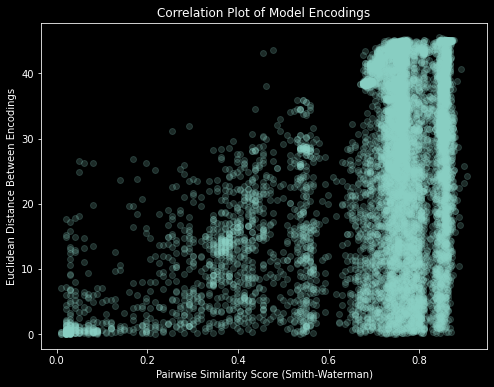

In [100]:
import random
from scipy.spatial.distance import euclidean
codes = BASES + ['N']
def to_str(s):
    return ''.join(codes[i] for i in s)
def evaluate():
    a = random.randint(0, anc_seq_reps.shape[0] - 1)
    b = random.randint(0, anc_seq_reps.shape[0] - 1)
    pred = euclidean(anc_seq_reps[a], anc_seq_reps[b])
    first = to_str(arlington_processed[a].argmax(-1))
    second = to_str(arlington_processed[b].argmax(-1))
    aln = align((first, second))
    score = np.tanh((300 - aln) / 100)
    return [score, pred]
results = np.asarray([evaluate() for i in tqdm(range(10000))])
f = plt.figure(figsize=(8, 6))
plt.scatter(results[:, 0], results[:, 1], alpha=.2)
plt.xlabel('Pairwise Similarity Score (Smith-Waterman)')
plt.ylabel('Euclidean Distance Between Encodings')
plt.title('Correlation Plot of Model Encodings')
plt.savefig(f'Results/it{ver}/anc/eval/comparative_enc_eval_anc.png')

In [101]:
np.corrcoef(results[:, 0], results[:, 1])

array([[1.        , 0.40169873],
       [0.40169873, 1.        ]])

In [102]:
np.mean((results[:, 0] - results[:, 1]) ** 2)

738.4940462631097

#### Full Dataset Visualization

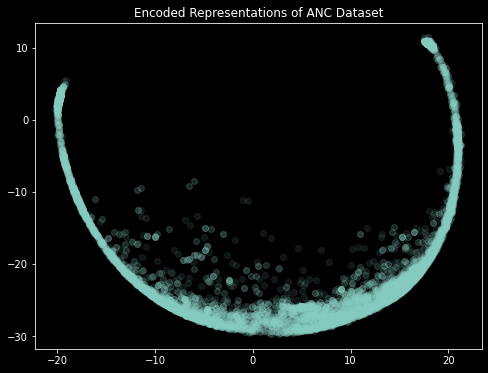

In [103]:
x, y = anc_seq_reps.T
f = plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=.1, marker='o')
plt.title("Encoded Representations of ANC Dataset")
plt.savefig(f'Results/it{ver}/anc/anc_all.png')

## Dataset Exploration

### Phylum

In [104]:
all_phyla, counts = np.unique(arlington_tax[:, 0], return_counts=True)
genuses = all_phyla[counts > 50]

In [105]:
plottable = np.isin(arlington_tax[:, 0], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[arlington_tax[plottable][:, 0] == genuses[i], i] = 1
plottable_seqs = anc_seq_reps[plottable]

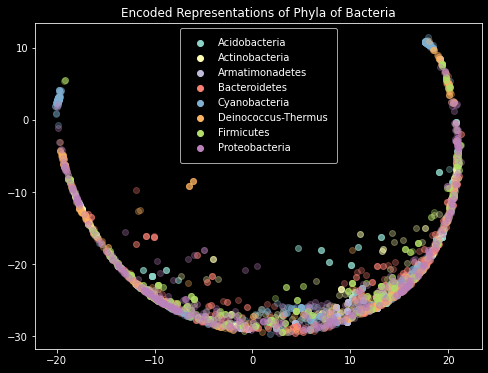

In [106]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 500)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Phyla of Bacteria")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig(f'Results/it{ver}/anc/anc_phylum.png')

### Variable Region

In [107]:
all_regions, counts = np.unique(v_region_labels, return_counts=True)
genuses = all_regions[counts > 50]

In [108]:
plottable = np.isin(v_region_labels, genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[v_region_labels[plottable] == genuses[i], i] = 1
plottable_seqs = anc_seq_reps[plottable]

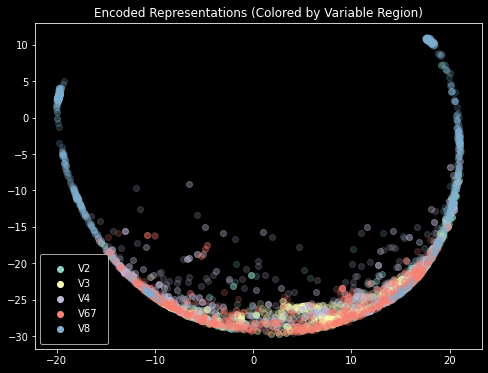

In [109]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.2, marker='o')
ax.set_title("Encoded Representations (Colored by Variable Region)")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig(f'Results/it{ver}/anc/anc_vregion.png')

### V8

In [110]:
subset = v_region_labels == 'V8'
arlington_tax_sub = arlington_tax[subset]
anc_2d_sub = anc_seq_reps[subset]
anc_lbl_sub = arlington_labels[subset]

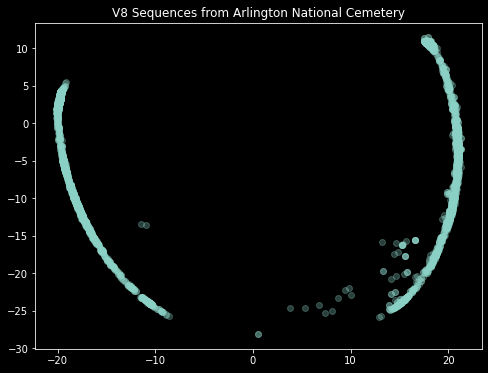

In [111]:
f = plt.figure(figsize=(8, 6))
plt.scatter(anc_2d_sub[:, 0], anc_2d_sub[:, 1], alpha=.3)
plt.title('V8 Sequences from Arlington National Cemetery')
plt.savefig(f'Results/it{ver}/anc/anc_v8.png')

#### Phylum

In [259]:
all_phyla, counts = np.unique(arlington_tax_sub[:, 0], return_counts=True)
genuses = all_phyla[counts > 50]

In [260]:
plottable = np.isin(arlington_tax_sub[:, 0], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[arlington_tax_sub[plottable][:, 0] == genuses[i], i] = 1
plottable_seqs = anc_2d_sub[plottable]

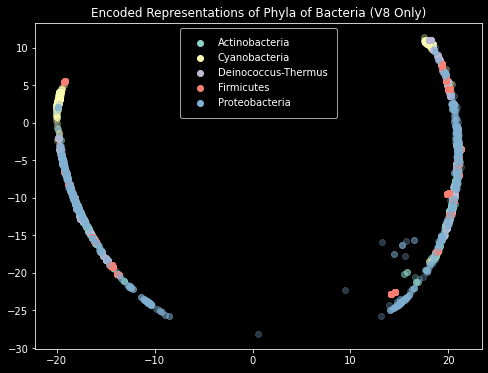

In [262]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Phyla of Bacteria (V8 Only)")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig(f'Results/it{ver}/anc/anc_v8_phylum.png')

#### Class

In [206]:
all_phyla, counts = np.unique(arlington_tax_sub[arlington_tax_sub[:, 0] == 'Proteobacteria'][:, 1], return_counts=True)
genuses = all_phyla[counts > 50]

In [207]:
plottable = np.isin(arlington_tax_sub[:, 1], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[arlington_tax_sub[plottable][:, 1] == genuses[i], i] = 1
plottable_seqs = anc_2d_sub[plottable]

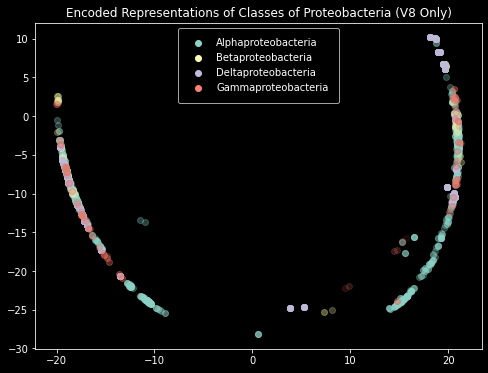

In [208]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
alphas = iter([.3, .03, .3, .03])
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=next(alphas), marker='o')
ax.set_title("Encoded Representations of Classes of Proteobacteria (V8 Only)")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig(f'Results/it{ver}/anc/anc_v8_class.png')

#### Order

In [223]:
all_phyla, counts = np.unique(arlington_tax_sub[arlington_tax_sub[:, 1] == 'Alphaproteobacteria'][:, 2], return_counts=True)
genuses = all_phyla[counts > 50]

In [224]:
plottable = np.isin(arlington_tax_sub[:, 2], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[arlington_tax_sub[plottable][:, 2] == genuses[i], i] = 1
plottable_seqs = anc_2d_sub[plottable]

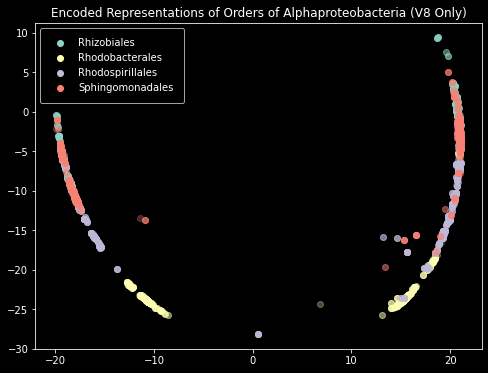

In [225]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Orders of Alphaproteobacteria (V8 Only)")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig(f'Results/it{ver}/anc/anc_v8_order.png')

#### Genus

In [252]:
all_phyla, counts = np.unique(arlington_tax_sub[arlington_tax_sub[:, 3] == 'Sphingomonadaceae'][:, 4], return_counts=True)
genuses = all_phyla[counts > 50]

In [253]:
plottable = np.isin(arlington_tax_sub[:, 4], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[arlington_tax_sub[plottable][:, 4] == genuses[i], i] = 1
plottable_seqs = anc_2d_sub[plottable]

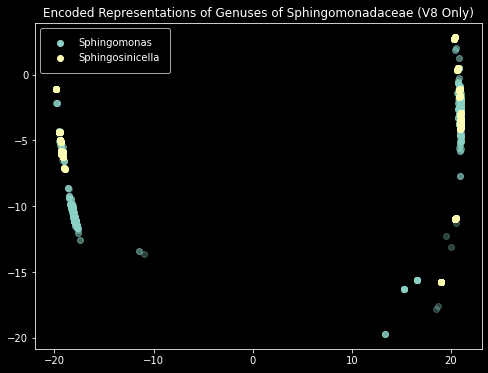

In [254]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Genuses of Sphingomonadaceae (V8 Only)")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig(f'Results/it{ver}/anc/anc_v8_genus.png')

#### Species

In [249]:
all_phyla, counts = np.unique(arlington_tax_sub[arlington_tax_sub[:, 4] == 'Sphingomonas'][:, 5], return_counts=True)
genuses = all_phyla[1:]

In [250]:
plottable = np.isin(arlington_tax_sub[:, 5], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[arlington_tax_sub[plottable][:, 5] == genuses[i], i] = 1
plottable_seqs = anc_2d_sub[plottable]

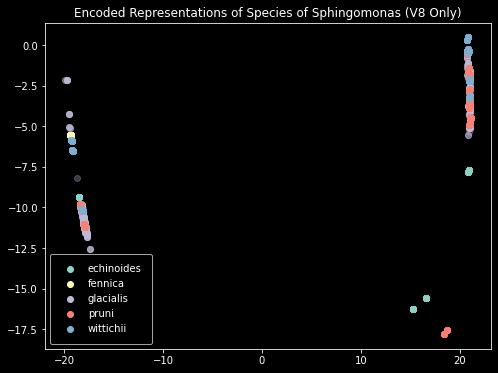

In [251]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Species of Sphingomonas (V8 Only)")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig(f'Results/it{ver}/anc/anc_v8_species.png')

#### Pigment

In [255]:
all_phyla, counts = np.unique(anc_lbl_sub, return_counts=True)
genuses = all_phyla[counts > 50]

In [256]:
plottable = np.isin(anc_lbl_sub, genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[anc_lbl_sub[plottable] == genuses[i], i] = 1
plottable_seqs = anc_2d_sub[plottable]

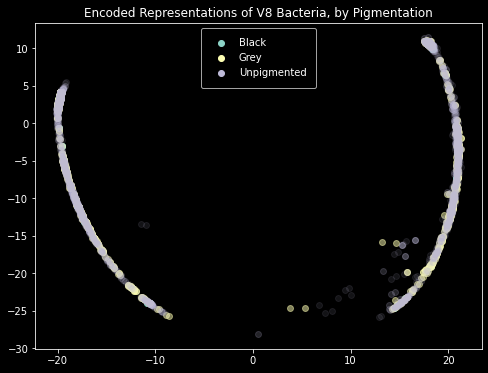

In [257]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
black, grey, unpigmented = anc_lbl_sub == 'black', anc_lbl_sub == 'grey', anc_lbl_sub == 'unpigmented'
plt.scatter(anc_2d_sub[black][:, 0], anc_2d_sub[black][:, 1], alpha=1)
plt.scatter(anc_2d_sub[grey][:, 0], anc_2d_sub[grey][:, 1], alpha=.5)
plt.scatter(anc_2d_sub[unpigmented][:, 0], anc_2d_sub[unpigmented][:, 1], alpha=.1)
ax.set_title("Encoded Representations of V8 Bacteria, by Pigmentation")
leg = plt.legend(['Black', 'Grey', 'Unpigmented'],
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig(f'Results/it{ver}/anc/anc_v8_pigment.png')